In [74]:
from __future__ import print_function
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from matplotlib import pyplot as plt
import copy
import time

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [76]:
# desired size of the output image
imsize =  (427, 640)
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Choose the style image folder by commenting and uncommenting the following lines
# style_img = image_loader("./images/northern_renaissance.jpeg") # Load the style image 
style_img = image_loader("./images/baroque.jpeg")
content_img = image_loader("./images/landscape.jpg") # Load the content image

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

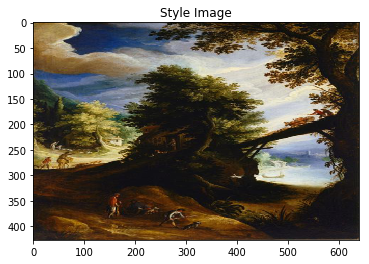

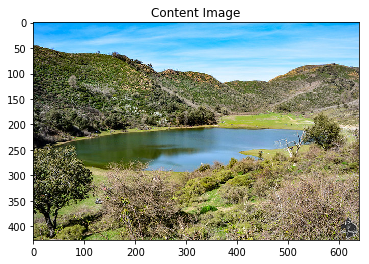

In [77]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def myimshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
myimshow(style_img, title='Style Image')

plt.figure()
myimshow(content_img, title='Content Image')

In [65]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()
        

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
#         self.loss = F.binary_cross_entropy_with_logits(input, self.target)
        return input

In [66]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [67]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [68]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [69]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [70]:
# desired depth layers to compute style/content losses :
# Uncomment the following lines to choose different structures

# content_layers_default = ['conv_3', 'conv_4', 'conv_5']
# content_layers_default = ['conv_4', 'conv_5']
content_layers_default = ['conv_4']
# style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7']
# style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
#             layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

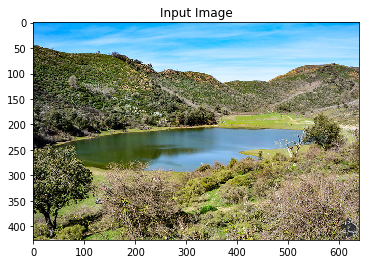

In [71]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
myimshow(input_img, title='Input Image')

In [72]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [73]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=600,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    print(model)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
            
                print() 

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
Optimizing..


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 2.007318 Content Loss: 5.638010

run [100]:
Style Loss : 1.743112 Content Loss: 4.819252

run [150]:
Style Loss : 1.677866 Content Loss: 4.556504

run [200]:
Style Loss : 1.654050 Content Loss: 4.415134

run [250]:
Style Loss : 1.642763 Content Loss: 4.337358

run [300]:
Style Loss : 1.676354 Content Loss: 4.480551

run [350]:
Style Loss : 1.638093 Content Loss: 4.319304

run [400]:
Style Loss : 1.666234 Content Loss: 4.473510

run [450]:
Style Loss : 1.620970 Content Loss: 4.270565

run [500]:
Style Loss : 1.630218 Content Loss: 4.258191

run [550]:
Style Loss : 1.847802 Content Loss: 5.125992

run [600]:
Style Loss : 1.648254 Content Loss: 4.231701

run [650]:
Style Loss : 1.614307 Content Loss: 4.167432

run [700]:
Style Loss : 1.597047 Content Loss: 4.140003

run [750]:
Style Loss : 1.620753 Content Loss: 4.201677

run [800]:
Style Loss : 1.886579 Content Loss: 6.164747

Processing done! Time comsumed:  59.703431129455566 s


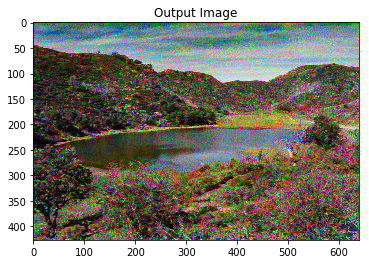

In [59]:
start = time.time()
output1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=800)
print('Processing done! Time comsumed: ', time.time()-start, 's')

plt.figure()
myimshow(output1, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [27]:
def pre_myimshow(image, ax=plt):
    image = image.to('cpu').clone().detach().numpy().squeeze()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
#     image = (image + 1) / 2
#     image[image < 0] = 0
#     image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

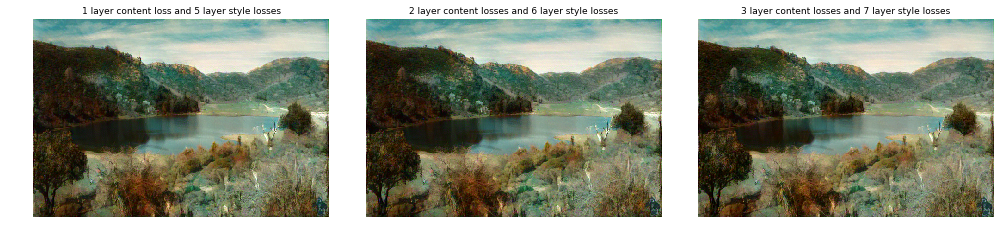

In [108]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(1,3,1)
pre_myimshow(output1)
ax1.set_title('1 layer content loss and 5 layer style losses', fontsize=9);
ax2 = fig.add_subplot(1,3,2)
pre_myimshow(output2)
ax2.set_title('2 layer content losses and 6 layer style losses', fontsize=9);
ax3 = fig.add_subplot(1,3,3)
pre_myimshow(output3)
ax3.set_title('3 layer content losses and 7 layer style losses', fontsize=9);
plt.tight_layout()